# Installation

In [ ]:
!pip install ThymeBoost

# Imports

In [ ]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from statsmodels.tsa.arima_model import ARIMA
from sklearn import metrics
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from ThymeBoost import ThymeBoost as tb
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tqdm import tqdm_notebook
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.holtwinters import Holt
from datetime import timedelta

import warnings
warnings.filterwarnings('ignore')

# Data Extraction

In [ ]:
#url of csv file
url = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'
#store data set in data frame named 'data'
data  = pd.read_csv(url)
#print data frame
data

,date,state,fips,cases,deaths
0,2020-01-21,Washington,53,1,0
1,2020-01-22,Washington,53,1,0
2,2020-01-23,Washington,53,1,0
3,2020-01-24,Illinois,17,1,0
4,2020-01-24,Washington,53,1,0
...,...,...,...,...,...
41385,2022-03-21,Virginia,51,1661484,19520
41386,2022-03-21,Washington,53,1448129,12421
41387,2022-03-21,West Virginia,54,496748,6651
41388,2022-03-21,Wisconsin,55,1581356,13994


**Description of Dataset**

---

Dataset has 5 columns :

1. **date** : Shows the date till which the covid cases are reported. The first covid case in US was reported on $21^{st}$ January, 2020. 
2. **state** : Shows the states of US where the covid cases were reported till a particular date. We are interested in state of **California** and so, we will filter records (rows) of state California only and hence, the state column will become useless and we will drop it. 
3. **fips** : FIPS stands for **Federal Information Processing Standards** and it is unique for a particular state. For california, fips is **06**. Since, fips is unique for each state and we are interested in California State only, so fips column will become redundant and we will drop it. 
4. **cases** : Shows the cumulative number of cases reported till a particular date in various states of US. The data is **continous** in term of date as we are using cumulative number of cases. 
5. **deaths** : Shows the number of deaths reported till a particular date in various states of US. 

So, our final dataset (Records for California State only) contains 3 columns : **date**, **cases**, **deaths** and we are going to predict **cases** for future dates using time series forcasting. 



In [ ]:
# Filtering records containing state = 'California' and storing it in dataframe named df : 
df = data.loc[data['state'] == 'California']
#reset index of data frame
df.reset_index(drop=True,inplace=True)
#print data frame df
df

,date,state,fips,cases,deaths
0,2020-01-25,California,6,1,0
1,2020-01-26,California,6,2,0
2,2020-01-27,California,6,2,0
3,2020-01-28,California,6,2,0
4,2020-01-29,California,6,2,0
...,...,...,...,...,...
782,2022-03-17,California,6,9054556,88015
783,2022-03-18,California,6,9061041,88131
784,2022-03-19,California,6,9064239,88156
785,2022-03-20,California,6,9064239,88162


# Data Preprocessing

In [ ]:
# Dropping columns : state and fips from data frame df
df = df.drop(['state','fips'],axis=1)
# Print data frame df
df

,date,cases,deaths
0,2020-01-25,1,0
1,2020-01-26,2,0
2,2020-01-27,2,0
3,2020-01-28,2,0
4,2020-01-29,2,0
...,...,...,...
782,2022-03-17,9054556,88015
783,2022-03-18,9061041,88131
784,2022-03-19,9064239,88156
785,2022-03-20,9064239,88162


In [ ]:
#checking whether data contains null values and dropping that records: 
df = df.dropna()
#print data frame df
df

,date,cases,deaths
0,2020-01-25,1,0
1,2020-01-26,2,0
2,2020-01-27,2,0
3,2020-01-28,2,0
4,2020-01-29,2,0
...,...,...,...
782,2022-03-17,9054556,88015
783,2022-03-18,9061041,88131
784,2022-03-19,9064239,88156
785,2022-03-20,9064239,88162


There are **no null values** in the data set and current number of records are **783** (upto date $17^{th}$ March, 2022).

In [ ]:
#Data Types of columns : 
df.dtypes

date      object
cases      int64
deaths     int64
dtype: object

Data type of **'date'** column is **object** and we need to convert it into **datetime** data type so that we can **subtract dates** and convert it into **int** data type which stores the number of days since starting of Covid in California.

In [ ]:
#Converting data type of column 'date' to datetime data type.
df['date'] = df['date'].astype('datetime64[ns]')
#New Data Types of Columns : 
df.dtypes

date      datetime64[ns]
cases              int64
deaths             int64
dtype: object

First covid case in California state was reported on $25^{th}$ January, 2020. So, we need to subtract this date from dates of date column in order to get number of days since $25^{th}$ January, 2020. 

In [ ]:
#Creating datetime object with date 25th January, 2020 and storing it in variable x.
x = datetime.datetime(2020,1,25)
#Subtracting x from dates stored in date column of data frame and storing the result in new column 'days'.
#Inserting column 'days' as first column. 
df.insert(0,'days','')
df['days'] = (df['date']-x).dt.days
#Print Data frame df
df

,days,date,cases,deaths
0,0,2020-01-25,1,0
1,1,2020-01-26,2,0
2,2,2020-01-27,2,0
3,3,2020-01-28,2,0
4,4,2020-01-29,2,0
...,...,...,...,...
782,782,2022-03-17,9054556,88015
783,783,2022-03-18,9061041,88131
784,784,2022-03-19,9064239,88156
785,785,2022-03-20,9064239,88162


Currently, number of records in data set are 783 i.e. last index value is 782 and last value in days column is 782 and hence, there are **no missing days** in the data set. Now, we need to predict number of cases in a particular date, so we should convert cumulative number of cases into number of cases on that particular date. This can be done by **subtracting cumulative number of cases on a day with cumulative number of cases on the previous day**. Same goes with deaths as well.

In [ ]:
#Updating the cases and deaths values in data frame : 
n = df.shape[0]
i = n-1
while(i > 0):
  df['cases'][i] = df['cases'][i]-df['cases'][i-1]
  df['deaths'][i] = df['deaths'][i]-df['deaths'][i-1]
  i -= 1
#print data frame
df

,days,date,cases,deaths
0,0,2020-01-25,1,0
1,1,2020-01-26,1,0
2,2,2020-01-27,0,0
3,3,2020-01-28,0,0
4,4,2020-01-29,0,0
...,...,...,...,...
782,782,2022-03-17,5839,146
783,783,2022-03-18,6485,116
784,784,2022-03-19,3198,25
785,785,2022-03-20,0,6


Now the data set is completly correct for doing prediction of number of cases on a particular date in California State. 

# Analyzing Data 

In [ ]:
#numpy arrays : days stores values in days columns of data frame df. 
#cases stores cases values in cases columns of data frame df.
#deaths stores deaths values in deaths columns of data frame df.
days = np.asarray(df['days'],dtype=int)
cases = np.asarray(df['cases'],dtype=int)
deaths = np.asarray(df['deaths'],dtype=int)

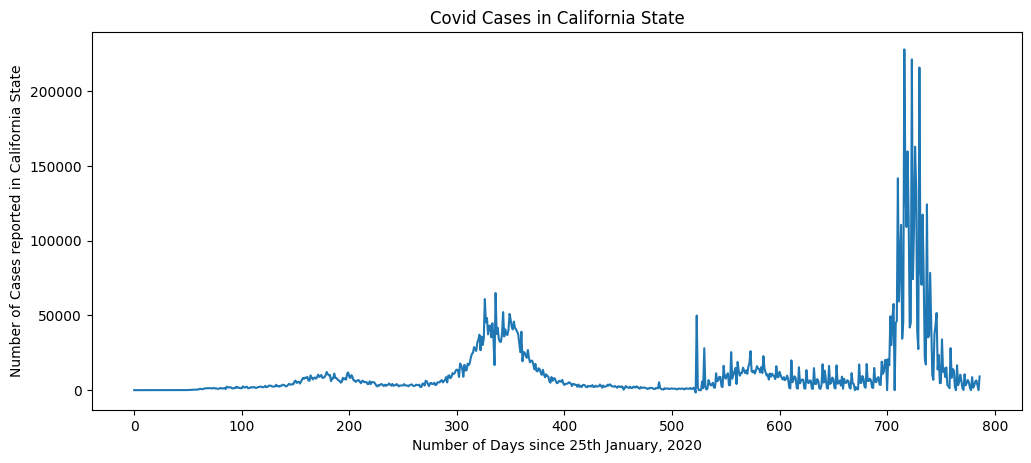

In [ ]:
#Plotting Line plot of number of cases vs days
fig=plt.figure(figsize=(12,5), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(days,cases)
plt.xlabel('Number of Days since 25th January, 2020')
plt.ylabel('Number of Cases reported in California State')
plt.title('Covid Cases in California State')
plt.show()

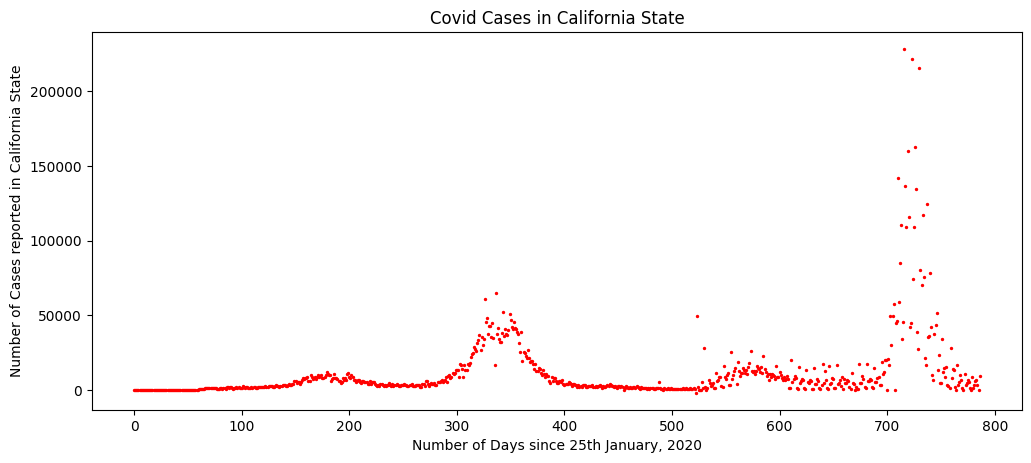

In [ ]:
#Plotting Scatter plot of number of cases vs days
fig=plt.figure(figsize=(12,5), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(days,cases,s=2,c='r')
plt.xlabel('Number of Days since 25th January, 2020')
plt.ylabel('Number of Cases reported in California State')
plt.title('Covid Cases in California State')
plt.show()

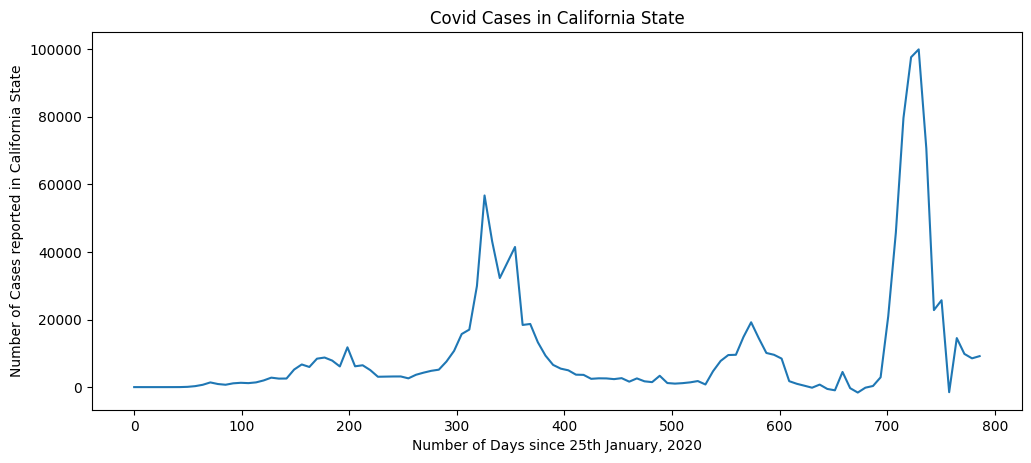

In [ ]:
#Plotting Spline Curve of number of cases vs days
fig=plt.figure(figsize=(12,5),dpi= 100,facecolor='w',edgecolor='k')
X_Y_Spline = make_interp_spline(days,cases)
days1 = np.linspace(days.min(),days.max(),int((days.max()-days.min())/7))
cases1 = X_Y_Spline(days1)
plt.plot(days1,cases1)
plt.xlabel('Number of Days since 25th January, 2020')
plt.ylabel('Number of Cases reported in California State')
plt.title('Covid Cases in California State')
plt.show()

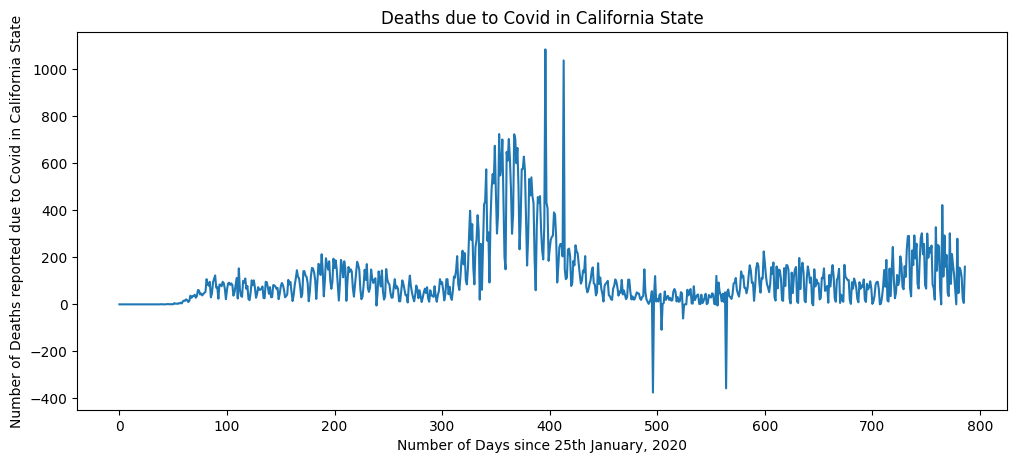

In [ ]:
#Plotting Line plot of number of deaths vs days
fig=plt.figure(figsize=(12,5),dpi= 100,facecolor='w',edgecolor='k')
plt.plot(days,deaths)
plt.xlabel('Number of Days since 25th January, 2020')
plt.ylabel('Number of Deaths reported due to Covid in California State')
plt.title('Deaths due to Covid in California State')
plt.show()

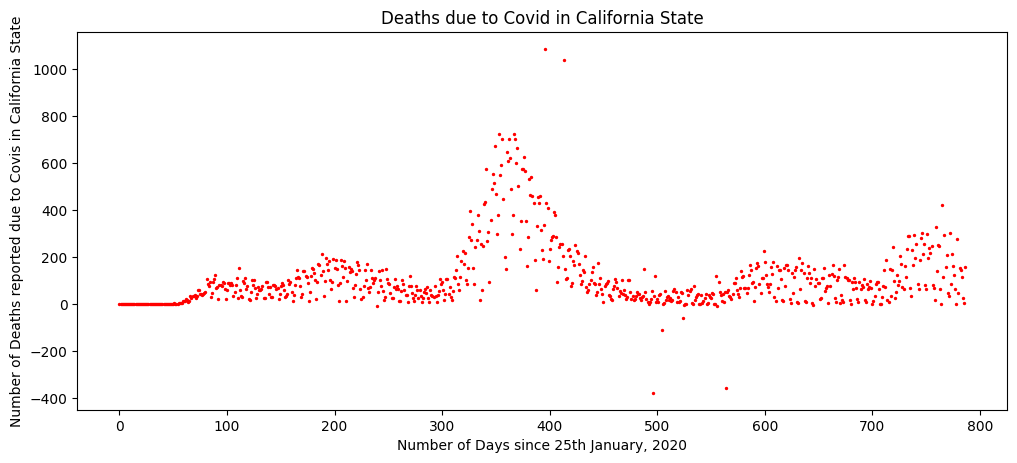

In [ ]:
#Plotting Scatter plot of number of deaths vs days
fig=plt.figure(figsize=(12,5), dpi= 100, facecolor='w', edgecolor='k')
plt.scatter(days,deaths,s=2,c='r')
plt.xlabel('Number of Days since 25th January, 2020')
plt.ylabel('Number of Deaths reported due to Covis in California State')
plt.title('Deaths due to Covid in California State')
plt.show()

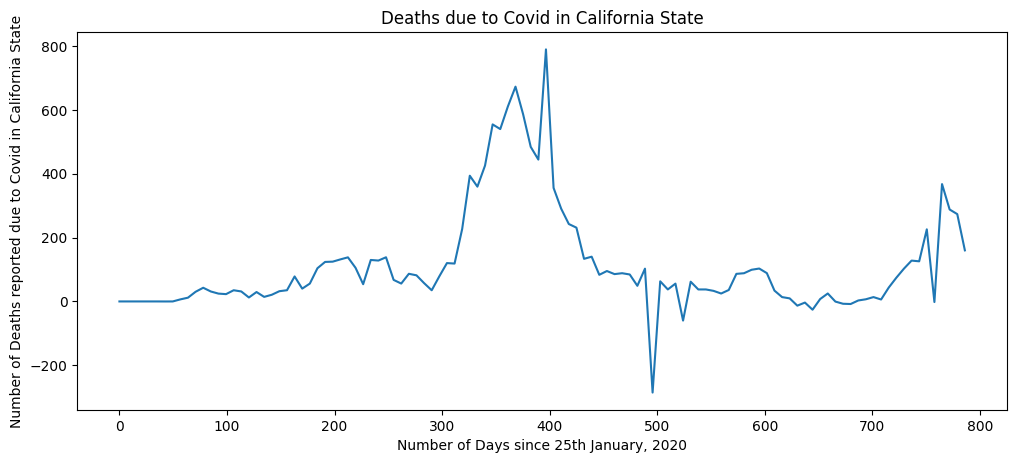

In [ ]:
#Plotting Spline Curve of number of deaths vs days
fig=plt.figure(figsize=(12,5),dpi= 100,facecolor='w',edgecolor='k')
X_Y_Spline = make_interp_spline(days,deaths)
days1 = np.linspace(days.min(),days.max(),int((days.max()-days.min())/7))
deaths1 = X_Y_Spline(days1)
plt.plot(days1,deaths1)
plt.xlabel('Number of Days since 25th January, 2020')
plt.ylabel('Number of Deaths reported due to Covid in California State')
plt.title('Deaths due to Covid in California State')
plt.show()

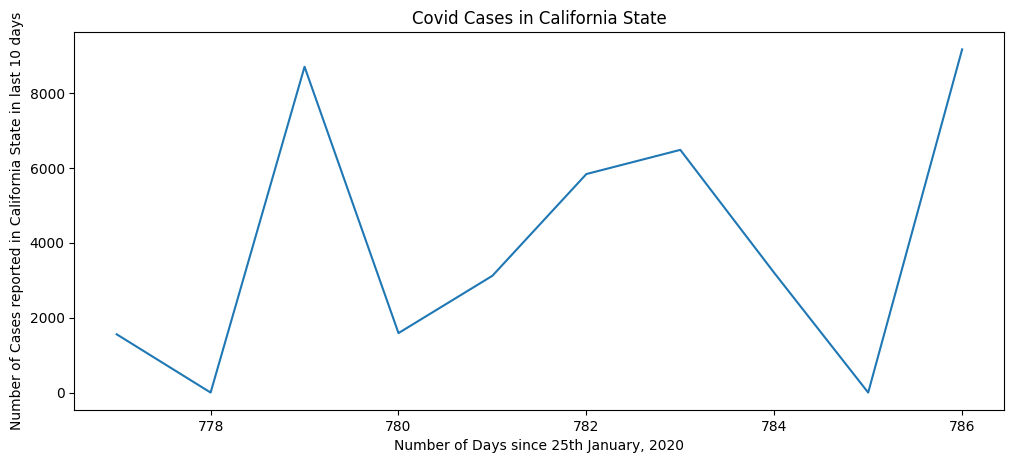

In [ ]:
#Visualizing last 10 days covid cases :
fig=plt.figure(figsize=(12,5), dpi= 100, facecolor='w', edgecolor='k')
plt.plot(days[-10:],cases[-10:])
plt.xlabel('Number of Days since 25th January, 2020')
plt.ylabel('Number of Cases reported in California State in last 10 days')
plt.title('Covid Cases in California State')
plt.show()

From the above graphs, we can conclude that currently covid cases in California is **decreasing**.

# Time Series Forcasting Models

I have used **'ARIMA'** model to predict the number of covid cases as it is a common method for time series forecasting.

## Evaluation Metrics

In [ ]:
# Accuracy metrics used for prediction
def forecast_accuracy(forecast,actual):
    mape = np.mean(np.abs(forecast-actual)/np.abs(actual+1))  # MAPE
    me = np.mean(forecast-actual)             # ME
    mae = np.mean(np.abs(forecast-actual))    # MAE
    mpe = np.mean((forecast-actual)/(actual+1))   # MPE
    rmse = np.mean((forecast-actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast,actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None],actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None],actual[:,None]]), axis=1)
    minmax = 1-np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 'mpe': mpe, 'rmse':rmse, 'corr':corr, 'minmax':minmax})

## ARIMA

**Arima (Auto Regressive Integrated Moving Average)** model requires 3 parameters **p,d and q**. 

* **p** : order of the AutoRegressive (AR) term
* **d** : number of differencing required to make the time series stationary
* **q** : order of the Moving Average (MA) term

Arima model works for stationary time series and so, if a time series is non-stationary, we difference it to make it stationary.


To check whether a series is stationary, I have used ADF Test (Augmented Dickey Fuller Test).

In [ ]:
#adfuller is used for ADF Test.
result = adfuller(df['cases'])
print('ADF Statistic: ',result[0])
print('p-value: %f',result[1])

ADF Statistic:  -4.236285732560909
p-value: %f 0.0005716609935345087


We gave obtained p-value = 0.000571 from **ADF Test (Augmented Dickey Fuller Test)** which is less than 0.05 and hence, we can say that our time series is stationary and so, d = 0.

To calculate **q**, I have used **ACF (Autocorrelation) Plot**. 

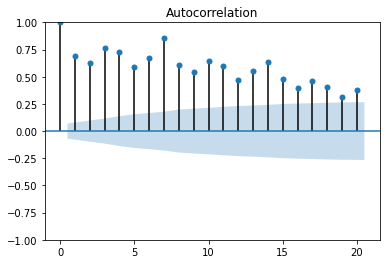

In [ ]:
#plot_acf is used for ACF plot.
#Showing first 20 lags.
plot_acf(df['cases'],lags=20)
plt.show()

From graph, we have there is a minima at lag = 2 and it is also above the confidence level. So, taking **q = 2** will be appropriate.

To calculate **p**, I have used **PACF (Partial Autocorrelation) plot**.

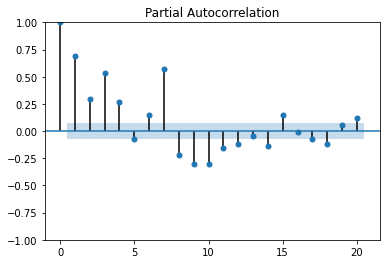

In [ ]:
plot_pacf(df['cases'],lags=20)
plt.show()

From the graph, we have there is a minima at lags = 6 and it is just above the confidence level. So, taking **p = 6** will be appropriate.

In [ ]:
#Fitting ARIMA model
model = SARIMAX(df['cases'],order=(6,0,2))  #order = (p,d,q)
model_fit = model.fit(disp=0)

In [ ]:
#Forecast of covid cases for next 15 days.
fc = model_fit.forecast(15)
dates = np.zeros(15,dtype=object)
i = 0
curr_date = df['date'][df.shape[0]-1]
while(i < 15):
  dat = curr_date+timedelta(i+1)
  dates[i] = dat
  i += 1
res_dates = pd.DataFrame(data=dates,columns=['Date'])
res_days = pd.DataFrame(data=fc.index,columns=['Days'])
res_cases = pd.DataFrame(data=fc.values,columns=['Cases'])
res_df = pd.concat([res_dates,res_days,res_cases],axis=1)
res_df

,Date,Days,Cases
0,2022-03-22,787,4944.598758
1,2022-03-23,788,2864.857994
2,2022-03-24,789,5590.562216
3,2022-03-25,790,6506.294244
4,2022-03-26,791,1834.163660
5,2022-03-27,792,3259.937554
6,2022-03-28,793,6097.372417
7,2022-03-29,794,4732.268664
8,2022-03-30,795,3510.203859
9,2022-03-31,796,5378.706154


So, Number of covid cases after 15 days i.e. on **05-04-2022** will be **4213**. This can be accurate as number of covid cases in California are declining and currently, each day there are around 13K cases in California and it is so we can estimate that cases will further fall and reach around 4000 mark. 

---



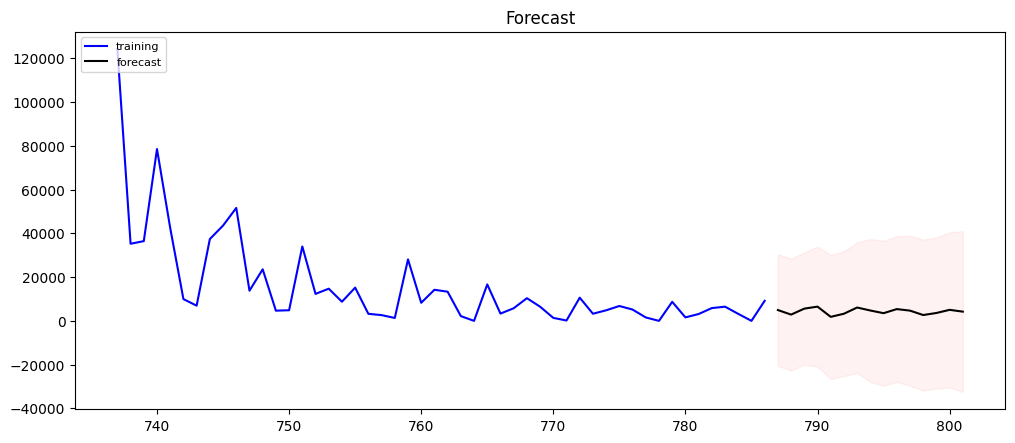

In [ ]:
# Plotting training and forecast 
fcast = model_fit.get_forecast(15)
conf = fcast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:,0])
upper_series = pd.Series(conf.iloc[:,1])
fc_series = pd.Series(fc,index=fc.index)

# Plot
plt.figure(figsize=(12,5),dpi=100)
plt.plot(df['cases'][-50:],label='training',c='b')
plt.plot(fc_series,label='forecast',c='k')
plt.fill_between(lower_series.index, lower_series, upper_series, color='r', alpha=.05)
plt.legend(loc='upper left',fontsize=8)
plt.title('Forecast')
plt.show()

### Testing for Last 15 days Forecast

In [ ]:
#Creating training and testing sets.
Xtrain = df['cases'][:-15]    #Training set
Xtest = df['cases'][-15:]     #Test set
#Fitting ARIMA model
model_1 = SARIMAX(Xtrain,order=(6,0,2))  #order = (p,d,q)
model_fit_1 = model_1.fit(disp=0)

In [ ]:
#Forecast of covid cases for next 15 days.
fc_1 = model_fit_1.forecast(15)
error = forecast_accuracy(fc_1,Xtest)
print("Errors are : ",error)

Errors are :  {'mape': 415.6279330905903, 'me': 551.3977120575526, 'mae': 2004.1257357599268, 'mpe': 415.38958398906647, 'rmse': 2453.5946950919274, 'corr': 0.6559615360021348, 'minmax': 0.3881559829049753}


So, in last 15 day forecast, we are getting **RMSE error or 2453**.

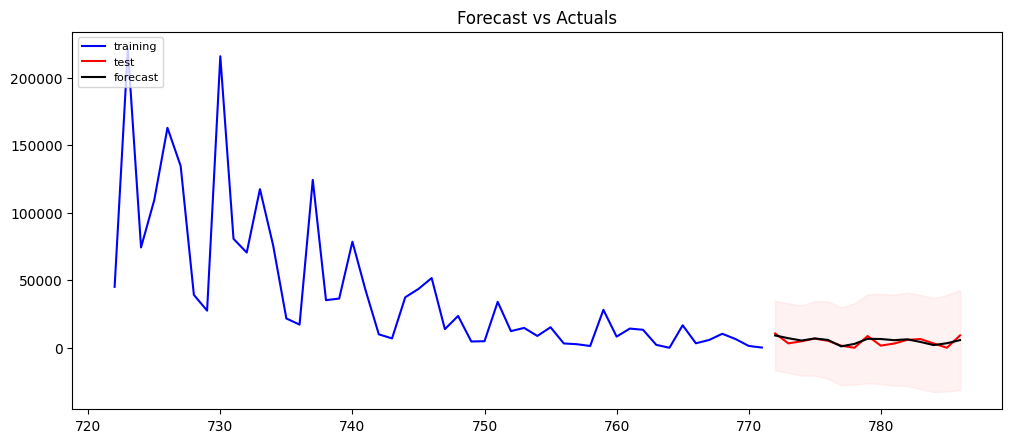

In [ ]:
# Plotting training and forecast 
fcast = model_fit_1.get_forecast(15)
conf = fcast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:,0])
upper_series = pd.Series(conf.iloc[:,1])
fc_series = pd.Series(fc_1,index=fc_1.index)

# Plot
plt.figure(figsize=(12,5),dpi=100)
plt.plot(Xtrain[-50:],label='training',c='b')
plt.plot(Xtest,label='test',c='r')
plt.plot(fc_series,label='forecast',c='k')
plt.fill_between(lower_series.index, lower_series, upper_series, color='r', alpha=.05)
plt.legend(loc='upper left',fontsize=8)
plt.title('Forecast vs Actuals')
plt.show()

As seen from the graph, our forecast is good.

### Cross Validation Evaluation

In [ ]:
#Time Series Cross Validation to evaluate performance of the model in intervals of 50.
arr = np.zeros((15,8))
df_cross = pd.DataFrame(arr,columns=['Days','mape','me','mae','mpe','rmse','corr','minmax'])
start = 500
end = df.shape[0]-15
cases = np.asarray(df['cases'])
num = 0
while(start <= end):
  cross_model = SARIMAX(cases[:start],order=(6,0,2))
  crm = cross_model.fit(disp=0)
  forecast = crm.forecast(15)
  i = 0
  while(i < 15):
    df_cross['Days'][i] = i+1
    actual = cases[start:start+i+1] 
    frc = forecast[0:i+1]
    error = forecast_accuracy(frc,actual)
    for k in error.keys():
      df_cross[k][i] += error[k]
    i += 1
  start += 50
  num += 1

df_cross.iloc[:,1:] = df_cross.iloc[:,1:]/num
df_cross

,Days,mape,me,mae,mpe,rmse,corr,minmax
0,1.0,2061.672142,2107.061985,3811.334073,2061.437632,3811.334073,NaN,0.382036
1,2.0,1031.027094,-319.376559,3609.027114,1030.717742,4048.928950,1.000000,0.332493
2,3.0,687.901300,1696.883217,4694.086518,687.631615,5692.643861,0.430928,0.347045
3,4.0,516.086206,559.036712,6329.843304,515.785991,7855.539966,0.344439,0.366762
4,5.0,413.033698,750.774871,6367.006326,412.760386,7756.160445,0.165348,0.372381
5,6.0,344.250938,-612.578460,6683.243452,343.952107,8484.162858,0.274372,0.360901
6,7.0,295.144802,-1350.012635,6919.909281,294.836130,8832.956299,0.302709,0.357034
7,8.0,563.512864,-744.372665,6610.876827,563.219081,8421.371569,0.312810,0.370071
8,9.0,501.236086,-888.041889,6987.635487,500.924672,8648.193694,0.294857,0.375524
9,10.0,451.326934,-1093.575429,7229.694846,451.005834,8892.638515,0.283757,0.389456


I have done cross validation for **15 days** forecast prediction. Here, I have started with training for first 500 days and then calculated the errors in forecast for next 15 days. Then I learn for 550 (500+50) days and calculated errors in forecast for next 15 days and so on in 50 days interval. 
The table shows the various errors values. So, for prediction on $15^{th}$ day, we have an average **RMSE error** of **13125**. 

## Analyzing Residuals 

In [ ]:
#Calculating residuals of a graph
residuals = model_fit.resid
df_res = pd.DataFrame(residuals,columns=['residuals'])
df_days = pd.DataFrame(df['days'].values,columns=['Days'])
df_dates = pd.DataFrame(df['date'].values,columns=['Dates'])
df_res = pd.concat([df_dates,df_days,df_res],axis=1)
df_res

,Dates,Days,residuals
0,2020-01-25,0,1.000000
1,2020-01-26,1,0.282911
2,2020-01-27,2,-0.803706
3,2020-01-28,3,-0.576651
4,2020-01-29,4,-0.719179
...,...,...,...
782,2022-03-17,782,398.564897
783,2022-03-18,783,2706.962185
784,2022-03-19,784,3449.748042
785,2022-03-20,785,-3686.692168


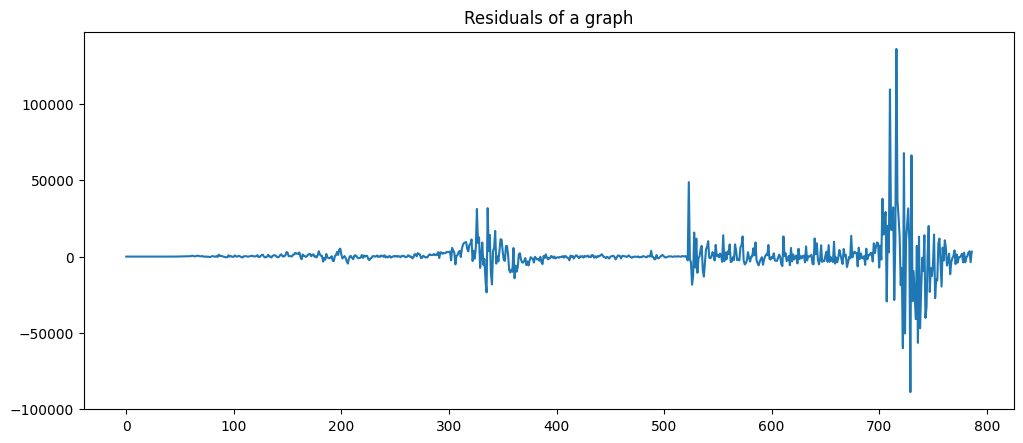

In [ ]:
#Plotting residuals of a graph
plt.figure(figsize=(12,5),dpi=100)
plt.plot(residuals)
plt.title('Residuals of a graph')
plt.show()

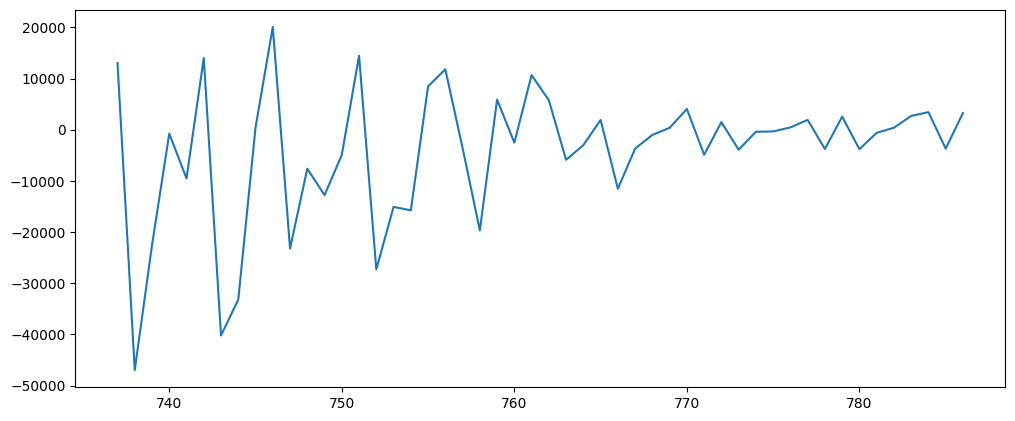

In [ ]:
#Plotting Residuals for last 50 days.
plt.figure(figsize=(12,5),dpi=100)
plt.plot(residuals[-50:])
plt.show()

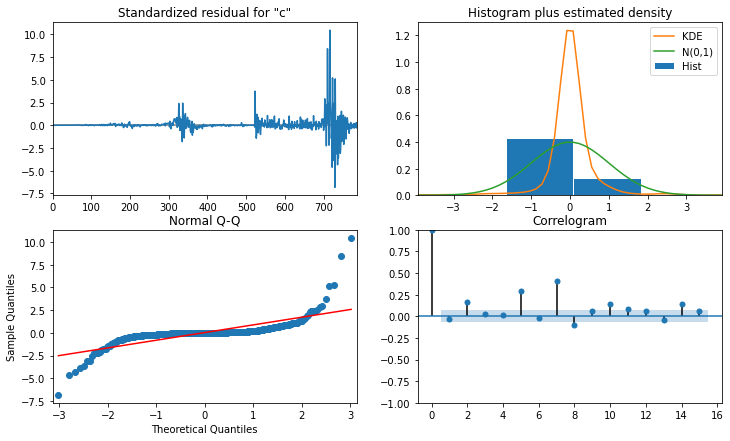

In [ ]:
model_fit.plot_diagnostics(figsize = (12,7),lags=15);

<Figure size 1200x500 with 0 Axes>

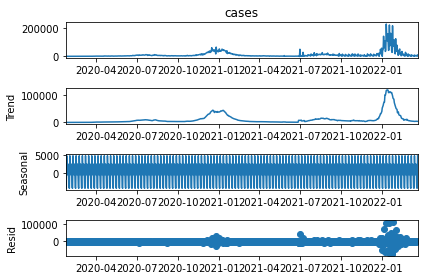

In [ ]:
arr = df.copy()
arr.set_index('date',inplace=True)
result = seasonal_decompose(arr['cases'],model='additive',extrapolate_trend='freq')
plt.figure(figsize=(12,5),dpi=100)
result.plot()
plt.show()

A good forecasting method will yield residuals with the following properties:

* **The residuals are uncorrelated :** If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
* **The residuals have zero mean :** If the residuals have a mean other than zero, then the forecasts are biased and we want forecast to be an **unbiased estimator** of training examples mean. 

In [ ]:
#Mean and Standard Deviation of residuals : 
res_mean = np.mean(residuals)
print("Mean of the residual is : ",res_mean)
res_deviation = np.std(residuals)
print("Standard Deviation of residuals is : ",res_deviation)

Mean of the residual is :  431.0717899990786
Standard Deviation of residuals is :  10981.761957948918


In [ ]:
#To check whether residuals are correlated or not, we use Durbin Watson Test.
val = durbin_watson(residuals)
print("Durbin-Watson statistic is : ",val)

Durbin-Watson statistic is :  2.0690529024729454


From Durbin Watson statistic, we found that it's value is 2.06 which is very close to 2 and so, we can say that the **residuals are uncorrelated**. 

After plotting the residuals of a graph, I have seen that between **700 to 750 days** residuals is very high i.e. between **-60K to 20K** and after 750 days residuals has been stabalized around 0 which should be. So, our model doesn't work well between 700 to 750 days. So, we can improve our accuracy of model if we consider **seasonality** as from the graph, we can see that we are getting some seasonality. Another way is we can consider **damped or exponential trends** instead of **constant trends** as seen from the shape of trends. \\
In residuals, we have a problem that it's mean is 431 and is not 0. So, in order to get mean = 0, we can subtract 431 from all the predictions we get. So, if we do that then our covid cases forecast for $15^{th}$ day will become **4213-431 = 3782**.

## Seasonality

Now, we use seasonality as from seasonality graph, we can deduce that time series is seasonal with seasonality (s) = 400. So, we can use seasonality of SARIMAX model to improve our results. For that again we need to find seasonal P,D and Q :

* **P** : order of the seasonal AutoRegressive (AR) term
* **D** : number of differencing required to make the seasonal time series stationary
* **Q** : order of the seasonal Moving Average (MA) term

Seasonal Arima model works for stationary time series and so, if a seasonal time series is non-stationary, we difference it to make it stationary.



In [ ]:
#Finding seasonal time series
seasonal = result.seasonal

In [ ]:
#Check whether seasonal time series is stationary or not using ADF Test.
res_adf = adfuller(seasonal)
print('ADF Statistic: ',res_adf[0])
print('p-value: ',res_adf[1])

ADF Statistic:  -6779555066304750.0
p-value:  0.0


We gave obtained p-value = 0.0 from **ADF Test (Augmented Dickey Fuller Test)** which is less than 0.05 and hence, we can say that our seasonal time series is stationary and so, D = 0.

To calculate **P**, I have used **PACF (Partial Autocorrelation) plot**.

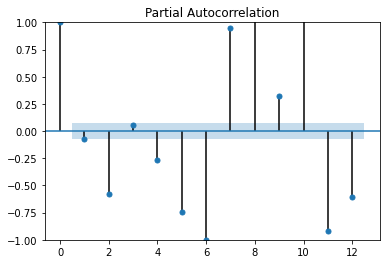

In [ ]:
plot_pacf(seasonal,lags =12)
plt.show()

From the graph, we have there is a minima at lags = 4 and it is above the confidence level. So, taking **P = 4** will be appropriate.

To calculate **Q**, I have used **ACF (Autocorrelation) Plot**.

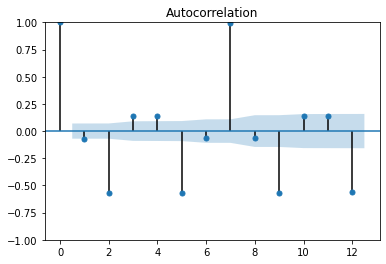

In [ ]:
plot_acf(seasonal, lags =12)
plt.show()

From graph, we have there is minima at lag = 3 and it is above the confidence level and so, taking **Q = 3** will be appropriate.

From the ACF and PACF plots, we can see that at lag = 7, we have correlation = 1 indicating **seasonality (s) = 7**.

In [ ]:
#Fitting SARIMA (Seasonal ARIMA) model
model_ses = SARIMAX(df['cases'],order=(2,0,2),seasonal_order=(4,0,3,7))  #order = (p,d,q) and seasonal_order = (P,D,Q,s)
model_fit_ses = model_ses.fit(disp=0)

In [ ]:
#Forecast of covid cases for next 15 days.
fc = model_fit_ses.forecast(15)
dates = np.zeros(15,dtype=object)
i = 0
curr_date = df['date'][df.shape[0]-1]
while(i < 15):
  dat = curr_date+timedelta(i+1)
  dates[i] = dat
  i += 1
res_dates = pd.DataFrame(data=dates,columns=['Date'])
res_days = pd.DataFrame(data=fc.index,columns=['Days'])
res_cases = pd.DataFrame(data=fc.values,columns=['Cases'])
res_df = pd.concat([res_dates,res_days,res_cases],axis=1)
res_df

,Date,Days,Cases
0,2022-03-22,787,4462.847196
1,2022-03-23,788,6994.431112
2,2022-03-24,789,5760.831108
3,2022-03-25,790,8017.832881
4,2022-03-26,791,3390.999082
5,2022-03-27,792,738.042645
6,2022-03-28,793,12765.484450
7,2022-03-29,794,5581.661645
8,2022-03-30,795,7042.157254
9,2022-03-31,796,8671.711698


So, Number of covid cases after 15 days i.e. on **05-04-2022** will be **6645** using seasonality. This can be accurate as number of covid cases in California are declining but not declining always and currently, each day there are around 13K cases in California and so we can estimate that cases will further fall and reach around 2000 mark around **03-04-2022** and then increase to **14077** on **04-04-2022** and then decrease to **6645** on **05-04-2022** following the trend. 

---



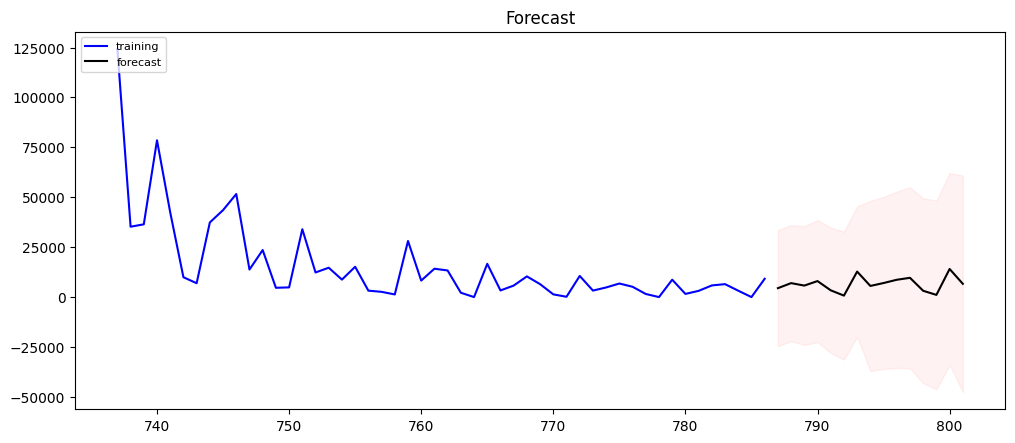

In [ ]:
# Plotting training and forecast 
fcast = model_fit_ses.get_forecast(15)
conf = fcast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:,0])
upper_series = pd.Series(conf.iloc[:,1])
fc_series = pd.Series(fc,index=fc.index)

# Plot
plt.figure(figsize=(12,5),dpi=100)
plt.plot(df['cases'][-50:],label='training',c='b')
plt.plot(fc_series,label='forecast',c='k')
plt.fill_between(lower_series.index, lower_series, upper_series, color='r', alpha=.05)
plt.legend(loc='upper left',fontsize=8)
plt.title('Forecast')
plt.show()

### Testing for Last 15 days Forecast using Seasonality

In [ ]:
#Creating training and testing sets.
Xtrain = df['cases'][:-15]    #Training set
Xtest = df['cases'][-15:]     #Test set
#Fitting SARIMA model
model_ses_1 = SARIMAX(Xtrain,order=(2,0,2),seasonal_order=(4,0,3,7))  #order = (p,d,q) and seasonal_order = (P,D,Q,s) 
model_fit_ses_1 = model_ses_1.fit(disp=0)

In [ ]:
#Forecast of covid cases for next 15 days.
fc_1 = model_fit_ses_1.forecast(15)
error = forecast_accuracy(fc_1,Xtest)
print("Errors are : ",error)
#Print Xtest 
df[-15:]

Errors are :  {'mape': 110.0941024628292, 'me': 115.72189402947566, 'mae': 2355.606864802036, 'mpe': -109.65050878122129, 'rmse': 2776.9028045816526, 'corr': 0.8933403972824703, 'minmax': inf}


,days,date,cases,deaths
772,772,2022-03-07,10598,302
773,773,2022-03-08,3257,87
774,774,2022-03-09,4825,214
775,775,2022-03-10,6798,165
776,776,2022-03-11,5165,125
777,777,2022-03-12,1557,64
778,778,2022-03-13,0,0
779,779,2022-03-14,8706,279
780,780,2022-03-15,1589,48
781,781,2022-03-16,3121,156


So, in last 15 day forecast, we are getting **RMSE of 2776** which is more than **2453** which we got without considering seasonality. The reason is that the data is not proper as we can see from Xtest values that there are days which has 0 covid cases which is not possible. So, these are outliers and we should remove it and then check.

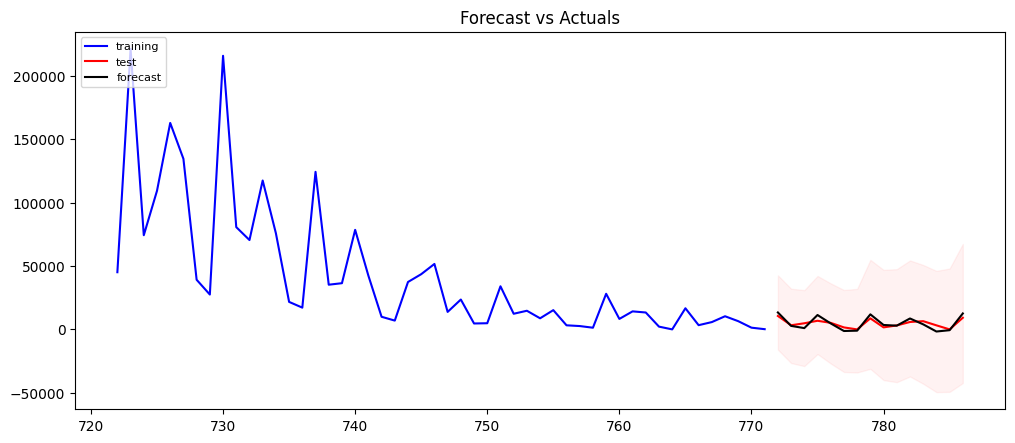

In [ ]:
# Plotting training and forecast 
fcast = model_fit_ses_1.get_forecast(15)
conf = fcast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:,0])
upper_series = pd.Series(conf.iloc[:,1])
fc_series = pd.Series(fc_1,index=fc_1.index)

# Plot
plt.figure(figsize=(12,5),dpi=100)
plt.plot(Xtrain[-50:],label='training',c='b')
plt.plot(Xtest,label='test',c='r')
plt.plot(fc_series,label='forecast',c='k')
plt.fill_between(lower_series.index, lower_series, upper_series, color='r', alpha=.05)
plt.legend(loc='upper left',fontsize=8)
plt.title('Forecast vs Actuals')
plt.show()

As seen from the graph our forecast is good.

### Cross Validation Evaluation using Seasonality

In [ ]:
#Time Series Cross Validation to evaluate performance of the model in intervals of 50.
arr = np.zeros((15,8))
df_cross = pd.DataFrame(arr,columns=['Days','mape','me','mae','mpe','rmse','corr','minmax'])
start = 500
end = df.shape[0]-15
cases = np.asarray(df['cases'])
num = 0
while(start <= end):
  cross_model = SARIMAX(cases[:start],order=(2,0,2),seasonal_order=(4,0,3,7)) #seasonal_order = (P,D,Q,s)
  crm = cross_model.fit(disp=0)
  forecast = crm.forecast(15)
  i = 0
  while(i < 15):
    df_cross['Days'][i] = i+1
    actual = cases[start:start+i+1] 
    frc = forecast[0:i+1]
    error = forecast_accuracy(frc,actual)
    for k in error.keys():
      df_cross[k][i] += error[k]
    i += 1
  start += 50
  num += 1

df_cross.iloc[:,1:] = df_cross.iloc[:,1:]/num
df_cross

,Days,mape,me,mae,mpe,rmse,corr,minmax
0,1.0,1929.224413,1940.808192,2693.599591,1929.114183,2693.599591,NaN,0.276843
1,2.0,964.812355,-837.502658,3967.209707,964.598292,4514.220880,0.333333,0.286293
2,3.0,643.522860,1421.378231,4950.405704,643.269190,5723.135508,0.397782,0.343341
3,4.0,482.815329,743.387048,6634.254913,482.538757,7906.539450,0.420718,0.358136
4,5.0,386.348037,408.525916,6080.098730,386.083231,7545.365303,0.357032,0.349769
5,6.0,322.031183,-616.352399,6485.458518,321.747525,8222.699075,0.380282,0.351266
6,7.0,276.076762,-1255.674919,6629.302107,275.802441,8483.194911,0.450277,0.339626
7,8.0,560.098937,-658.528209,6305.288815,559.848093,8098.107417,0.459282,0.347385
8,9.0,498.266570,-748.438682,6835.047432,497.989878,8540.922505,0.414474,0.360567
9,10.0,448.597154,-884.572460,6958.475846,448.315409,8619.116673,0.434770,0.370581


Here I have got better RMSE scores and for $15^{th}$ day, it is **12942** which is better than without seasonality i.e. **13125**. We can also try taking different seasonality and check our results.

## Holt Winter's Smoothing

**Holt Winter’s smoothing** technique allows us to include seasonality while making the prediction along with the trend. So, as we have trends and seasonality in our data, so we should use Holt Winter's smoothing. \\
In Holt Winter’s smoothing, we can find **exponential and damped trends** which is there in our data.
The problem with this is we require data should be strictly positive and so, we need to do that.

### Testing for Last 15 days Forecast using Holt Winter Smoothing

In [ ]:
#Creating training and testing sets.
Xtrain = df['cases'][:-15].copy()    #Training set
Xtest = df['cases'][-15:].copy()   #Test set
Xtrain = np.where(Xtrain<0,0,Xtrain)
Xtest = np.where(Xtest<0,0,Xtest)
#Fitting Holt model
model_holt_1 = Holt(Xtrain+1,exponential=True,damped_trend=True,initialization_method='Estimated')
model_fit_holt_1 = model_holt_1.fit()

In [ ]:
#Forecast of covid cases for next 15 days.
fc_1 = model_fit_holt_1.forecast(15)
error = forecast_accuracy(fc_1-1,Xtest)
print("Errors are : ",error)
#Print Xtest 
df[-15:]

Errors are :  {'mape': 647.6386216910901, 'me': 163.74019179744423, 'mae': 2671.006813709638, 'mpe': 647.342067199834, 'rmse': 3172.4279512468793, 'corr': -0.1641281525002578, 'minmax': 0.44041776694054346}


,days,date,cases,deaths
772,772,2022-03-07,10598,302
773,773,2022-03-08,3257,87
774,774,2022-03-09,4825,214
775,775,2022-03-10,6798,165
776,776,2022-03-11,5165,125
777,777,2022-03-12,1557,64
778,778,2022-03-13,0,0
779,779,2022-03-14,8706,279
780,780,2022-03-15,1589,48
781,781,2022-03-16,3121,156


So, in last 15 day forecast, we are getting **RMSE of 3172** which is more than **2453** which we got without considering trends. The reason is that the data is not proper as we can see from Xtest values that there are days which has 0 covid cases which is not possible. So, these are outliers and we should remove it and then check.

### Cross Validation using Holt Winter's Smoothing

In [ ]:
#Time Series Cross Validation to evaluate performance of the model in intervals of 50.
arr = np.zeros((15,8))
df_cross = pd.DataFrame(arr,columns=['Days','mape','me','mae','mpe','rmse','corr','minmax'])
start = 500
end = df.shape[0]-15
cases = np.asarray(df['cases'])
cases = np.where(cases<0,0,cases)
cases += 1
num = 0
while(start <= end):
  cross_model = Holt(cases[:start],exponential=True,damped_trend=True,initialization_method='Estimated') 
  crm = cross_model.fit()
  forecast = crm.forecast(15)
  i = 0
  while(i < 15):
    df_cross['Days'][i] = i+1
    actual = cases[start:start+i+1] 
    frc = forecast[0:i+1]
    error = forecast_accuracy(frc-1,actual-1)
    for k in error.keys():
      df_cross[k][i] += error[k]
    i += 1
  start += 50
  num += 1

df_cross.iloc[:,1:] = df_cross.iloc[:,1:]/num
df_cross

,Days,mape,me,mae,mpe,rmse,corr,minmax
0,1.0,2487.048995,5634.040091,6595.131163,2486.940500,6595.131163,NaN,0.371647
1,2.0,1243.861349,1956.501391,5058.619465,1243.692102,5673.457898,-3.700743e-17,0.312343
2,3.0,829.616335,2227.548203,4799.385608,829.460774,5449.882871,-2.905054e-02,0.315009
3,4.0,622.380660,643.222345,6242.860321,622.157577,7455.139812,-6.555749e-02,0.346393
4,5.0,498.086659,900.332298,6393.844381,497.874582,7443.097043,-2.327082e-01,0.366872
5,6.0,415.177827,-207.324567,7219.809027,414.925502,8591.801830,-8.422948e-02,0.385275
6,7.0,356.066839,-561.073101,7841.513644,355.811303,9355.986692,-5.523148e-02,0.381006
7,8.0,623.901891,364.070176,7780.906888,623.671122,9243.340116,-1.180992e-01,0.389051
8,9.0,554.955600,169.948004,8084.303185,554.705875,9443.948347,-1.007294e-01,0.393280
9,10.0,499.679517,-265.900582,8182.963883,499.415630,9630.092658,-4.734609e-02,0.402113


We are getting RMSE of **13978** which is more than what we got from ARIMA model. This may be because we are considering data from starting and initially there is no trend. 

# Outliers Detection

I have used **ThymeBoost** for outlier detection. ThymeBoost is commomly used for outlier detection in time series forecasting. ThymeBoost takes traditional time series decomposition and combines it with **gradient boosting**. The benefits of using thymeboost is it do gradient boosting which helps to figure out residuals and so, outliers. The disadvantage is that it fails sometimes when there is large noise in the data. \\
I have another approach for outliers detection when say we are at $n^{th}$ day, then we look at it's neighbours. Sometimes we have their neighbours i.e. $(n-1)^{th}$ and $(n+1)^{th}$ day have same value but $n^{th}$ day has very different value than that. Then we can say that $n^{th}$ day is an outlier as we are reporting covid cases and such drastic changes in a day can't happens. This approach will give correct outliers almost all time but it might happen that some point is a outlier but it doesn't predict it. 
So, we can combine these two approaches and then find the outliers.

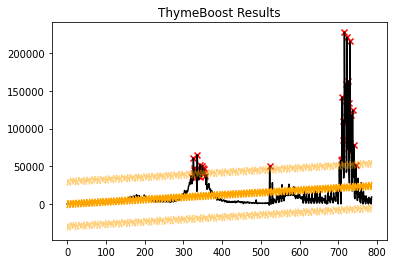

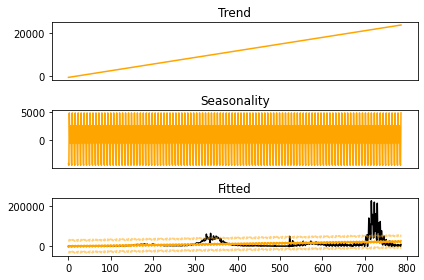

In [ ]:
#Outliers Calculation using ThymeBoost
cases = df['cases'].copy()
boosted_model = tb.ThymeBoost()
output = boosted_model.detect_outliers(cases,
                                       trend_estimator='linear',
                                       seasonal_estimator='fourier',
                                       seasonal_period=7,
                                       global_cost='maicc',
                                       fit_type='global')
boosted_model.plot_results(output)
boosted_model.plot_components(output)

In [ ]:
#Converting weights from True/False to 0 and 1. So, 0 value denotes it is an outlier.
weights = np.invert(output['outliers'].values) * 1
weights

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

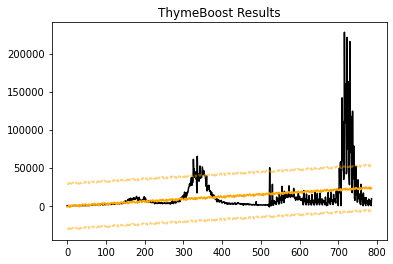

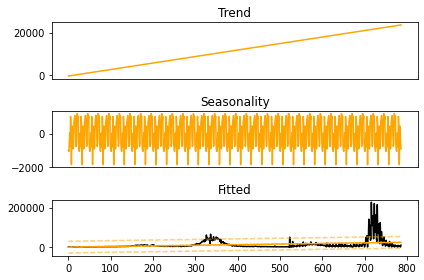

In [ ]:
#Checking after removal of outliers, is there any other outliers.
output = boosted_model.fit(cases,
                           trend_estimator='linear',
                           seasonal_estimator='fourier',
                           seasonal_period=25,
                           global_cost='maicc',
                           fit_type='global',
                           seasonality_weights=weights)
boosted_model.plot_results(output)
boosted_model.plot_components(output)

No other outlier detected.

In [ ]:
#Updating the value of outliers with their previous day value.
i = 0
while(i < cases.shape[0]):
  if(weights[i] == 0):
    cases[i] = cases[i-1]
  i += 1

## Forecasting after removing outliers

In [ ]:
#adfuller is used for ADF Test.
result = adfuller(cases)
print('ADF Statistic: ',result[0])
print('p-value: %f',result[1])

ADF Statistic:  -3.0538567924714504
p-value: %f 0.030161856626236747


p-value is less than 0.05 and hence, **d = 0**.

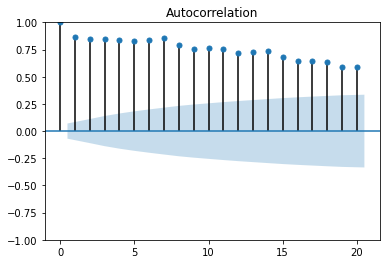

In [ ]:
#plot_acf is used for ACF plot.
#Showing first 20 lags.
plot_acf(cases,lags=20)
plt.show()

Minima is attained at lags = 2 and so, **q = 2**.

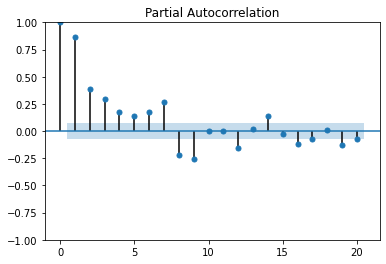

In [ ]:
#plot_pacf is used for PACF plot.
#Showing first 20 lags.
plot_pacf(cases,lags=20)
plt.show()

At lags = 8, we there is a minima and it is well above confidence level. So, **p = 8**.

In [ ]:
#forecasting for next 15 days.
model_outliers = SARIMAX(cases,order=(8,0,2))
model_outliers = model_outliers.fit()

In [ ]:
#Forecast of covid cases for next 15 days.
fc = model_outliers.forecast(15)
dates = np.zeros(15,dtype=object)
i = 0
curr_date = df['date'][df.shape[0]-1]
while(i < 15):
  dat = curr_date+timedelta(i+1)
  dates[i] = dat
  i += 1
res_dates = pd.DataFrame(data=dates,columns=['Date'])
res_days = pd.DataFrame(data=fc.index,columns=['Days'])
res_cases = pd.DataFrame(data=fc.values,columns=['Cases'])
res_df = pd.concat([res_dates,res_days,res_cases],axis=1)
res_df

,Date,Days,Cases
0,2022-03-22,787,3762.556276
1,2022-03-23,788,2966.231833
2,2022-03-24,789,6277.052015
3,2022-03-25,790,5620.118378
4,2022-03-26,791,2626.446569
5,2022-03-27,792,3217.472718
6,2022-03-28,793,7266.927537
7,2022-03-29,794,4574.685676
8,2022-03-30,795,2343.473644
9,2022-03-31,796,5653.046855


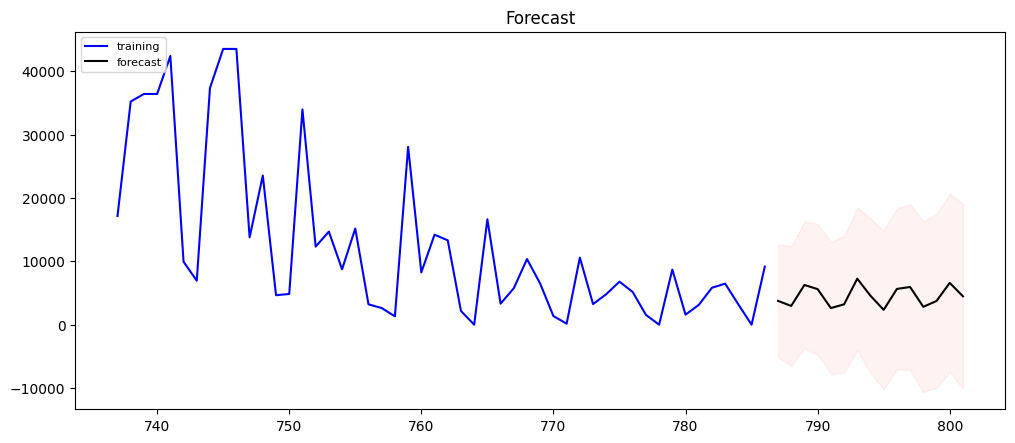

In [ ]:
# Plotting training and forecast 
fcast = model_outliers.get_forecast(15)
conf = fcast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:,0])
upper_series = pd.Series(conf.iloc[:,1])
fc_series = pd.Series(fc,index=fc.index)

# Plot
plt.figure(figsize=(12,5),dpi=100)
plt.plot(cases[-50:],label='training',c='b')
plt.plot(fc_series,label='forecast',c='k')
plt.fill_between(lower_series.index, lower_series, upper_series, color='r', alpha=.05)
plt.legend(loc='upper left',fontsize=8)
plt.title('Forecast')
plt.show()

Total number of covid cases after 15 days i.e. on **05-04-2022** will be **4484**.

### Testing for Last 15 days forecast

In [ ]:
model_outliers = SARIMAX(cases[:-15],order=(8,0,2))
model_outliers = model_outliers.fit()

In [ ]:
forecast = model_outliers.forecast(15)
error = forecast_accuracy(forecast,cases[-15:])
print("Error : ",error)

Error :  {'mape': 417.6178934031974, 'me': 370.5653857417357, 'mae': 1871.433647182867, 'mpe': 417.3989743260661, 'rmse': 2263.322604677397, 'corr': 0.7196180123222496, 'minmax': 0.37005860368740506}


Obtained **RMSE = 2263**

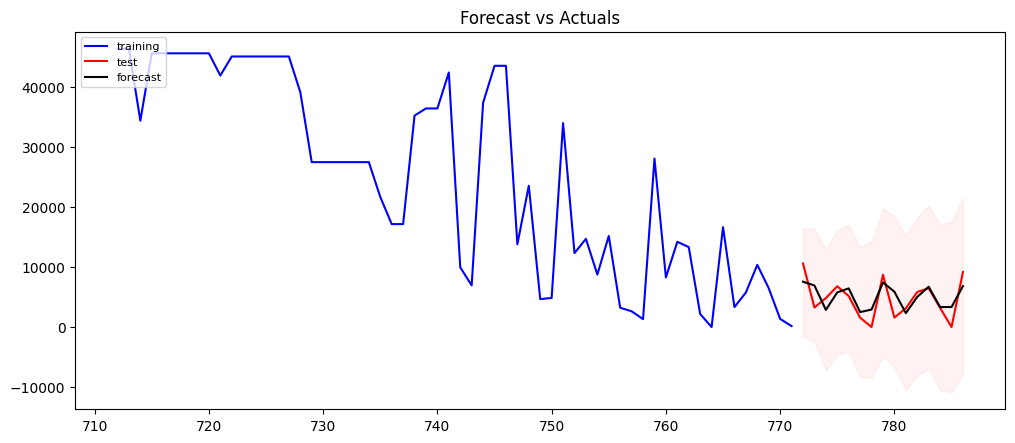

In [ ]:
# Plotting training and forecast 
fcast = model_outliers.get_forecast(15)
conf = fcast.conf_int(alpha=0.05)
lower_series = pd.Series(conf.iloc[:,0])
upper_series = pd.Series(conf.iloc[:,1])
fc_series = pd.Series(forecast,index=forecast.index)

# Plot
plt.figure(figsize=(12,5),dpi=100)
plt.plot(cases[-75:-15],label='training',c='b')
plt.plot(cases[-15:],label='test',c='r')
plt.plot(fc_series,label='forecast',c='k')
plt.fill_between(lower_series.index, lower_series, upper_series, color='r', alpha=.05)
plt.legend(loc='upper left',fontsize=8)
plt.title('Forecast vs Actuals')
plt.show()

After removing outliers, we have **reduce the RMSE from 2453 to 2263**. So, removal of outliers has made our forecast more accurate.

# Live Production

I can store trained models with training data upto every point of time in the past 30 days.

Now, I make predictions on these stored models for next 15 days and since, I have a live data now for models stored between past 30 days and past 15 days, I can check the errors obtained in these models. So, if my errors are fine, my model is good and if it is not then I need to create another model. In this way I can determine the quality of model and in each day we will be storing model trained on complete data available till now and remove model stored at last $30^{th}$ day. 

# Conclusion

So, I have done the covid data analysis for California state. The first covid case in California was reported on $25^{th}$ January, 2020. \\
In the covid data given, I have seen in many days, the covid case reported are 0 which is incorrect and so, this should be rectified in future. \\
Currently, in california, the covid cases are declining. \\
For time series forecasting I have used **ARIMA model** and from that, I got that number of covid cases that will be reported on **05-04-22** will be **4213**. Then I removed the outliers using **Thymeboost** and got that the number of covid cases that will be reported on **05-04-22** will be **4484**. \\
I studied the residuals of the model and got that there is a **trend** and **seasonality** in the data which I have not encountered in ARIMA model. So, for **seasonality**, I used SARIMA and got a reduced RMSE score than ARIMA model by crossvalidation for part 400 days. But for testing on past 15 days forecast, I got more RMSE more than ARIMA model. \\
For, **trends**, I used Holt Winter's smoothing to encounter exponential and damping trends but I didn't get good result on it. \\
The reason for not getting good result could be becuase data is not correct (as there are many 0 cases) or currently, as covid cases has declined substanitially, so trends and seasonality doesn't has important role to play. \\
So, according to me, the number of covid cases that will be reported on **05-04-22** will be **4484**.